## Question Answering
In this exercise, you will experiment with one of NLP’s exciting tasks - Question Answering!

You will first evaluate a pre-trained model on Squad, a leading question-answering dataset, and evaluate its performance. Those with an approved access to GPUs in AWS or a different provider are encouraged to also fine-tune a base model on the Squad dataset.

We will use HuggingFace’s Transformers, the leading package for NLP tasks using transformers. Your code should roughly follow the code of [this guide](https://huggingface.co/docs/transformers/tasks/question_answering) and [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/question_answering.ipynb).  

(**Important Note:** The guide writes considerable amount of code to handle the case of context longer than the max input sequence. For simplicity, in your code, you should remove from the datasets all contexts longer than
`max_length = 384`)


This exercise utilizes large models. While we only fine-tune existing models, the time required for fine-tuning could be still large so you are not expected to make many runs.


Install the transformers, datasets libraries

In [ ]:
# ! pip install datasets transformers

Import required libraries.  
Make sure your version of Transformers is at least 4.11.0.

In [1]:
import transformers

print(transformers.__version__)

4.32.1


We will use the 🤗 [Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric.

For our example here, we'll use version 1.1 of Stanford's [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/).

Load the Squad v1.1 dataset.

In [2]:
from datasets import load_dataset, load_metric

datasets = load_dataset("squad")

### Getting to know the dataset

The datasets object itself is DatasetDict, which contains one key for the training, validation and test set.

In [3]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [4]:
datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

Now, answer these questions:  

What is the shortest context in the training dataset?


In [5]:
shortest_context = min(datasets["train"]['context'], key=len)
print("Shortest context:", shortest_context)
print("Length of shortest context:", len(shortest_context))

Shortest context: Meanwhile, the USSR continued briefly trying to perfect their N1 rocket, finally canceling it in 1976, after two more launch failures in 1971 and 1972.
Length of shortest context: 151


What is the longest answer in the dataset?

In [6]:
longest_answer = max(datasets["train"]['answers'], key=lambda ans: len(max(ans['text'], key=len)))

print("Longest answer:", max(longest_answer['text'], key=len))
print("Length of longest answer:", len(max(longest_answer['text'], key=len)))


Longest answer: that the sudden shift of a huge quantity of water into the region could have relaxed the tension between the two sides of the fault, allowing them to move apart, and could have increased the direct pressure on it, causing a violent rupture
Length of longest answer: 239


Is there a question that appears multiple times? What is the most common question?

In [7]:
from collections import Counter

Counter(datasets["train"]['question']).most_common(10)

[('Who won this season of Idol?', 6),
 ('Which Caribbean nation is in the top quartile of HDI (but missing IHDI)?',
  6),
 ("I couldn't could up with another question. But i need to fill this space because I can't submit the hit. ",
  6),
 ('Who was a pop idol that started on American Idol?', 5),
 ('dd', 4),
 ('When was the region under Tibetan empire and the CHinese?', 3),
 ('Who took control of the regin in 710?', 3),
 ('Who restored Persian control of the region?', 3),
 ('What was the name of the region when it was the cultural center of Iran?',
  3),
 ('What is the official name of Portugal?', 3)]

There are three most common quations that appear 6 times in the dataset:
- 'Who won this season of Idol?'
- 'Which Caribbean nation is in the top quartile of HDI (but missing IHDI)?'
- "I couldn't could up with another question. But i need to fill this space because I can't submit the hit. "

### HuggingFace transformers’ tokenizers
As a preprocessing step, the HuggingFace code tokenizes input sequences using a Tokenizer. Read more about tokenizers here:
https://huggingface.co/docs/tokenizers/pipeline  
https://huggingface.co/transformers/v3.0.2/preprocessing.html

For this question, use the BERT tokenizer. The tokenizer sometimes breaks words into smaller chunks, so the number of tokens can be larger than the number of words.

Using the first 1,000 context datapoints, print the 30 most common tokens by the tokenizer.


In [8]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [10]:
tokenized_squad = datasets.map(preprocess_function, batched=True, remove_columns=datasets["train"].column_names)

In [11]:
# extract the first 1000 tokenized contexts
first_1000 = tokenized_squad['train'].select(range(1000))

# a counter to hold our token counts
token_counter = Counter()

for example in first_1000:
    # convert token ids back to tokens
    tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
    # update the counter
    token_counter.update(tokens)

# get the 30 most common tokens
most_common_tokens = token_counter.most_common(30)

for token, count in most_common_tokens:
    print(f"Token: {token}, Count: {count}")


Token: [PAD], Count: 183766
Token: the, Count: 10653
Token: ,, Count: 10558
Token: ., Count: 7327
Token: in, Count: 4986
Token: and, Count: 4682
Token: ", Count: 4500
Token: of, Count: 4394
Token: beyonce, Count: 2831
Token: a, Count: 2772
Token: ', Count: 2457
Token: to, Count: 2280
Token: s, Count: 2219
Token: her, Count: 2021
Token: [SEP], Count: 2000
Token: -, Count: 1869
Token: for, Count: 1762
Token: on, Count: 1691
Token: was, Count: 1538
Token: with, Count: 1361
Token: as, Count: 1329
Token: at, Count: 1298
Token: she, Count: 1171
Token: ?, Count: 1014
Token: [CLS], Count: 1000
Token: by, Count: 851
Token: is, Count: 814
Token: album, Count: 796
Token: that, Count: 751
Token: (, Count: 701


### Load a pretrained Question Answering model
In this section, you will use a model pretrained on the Squad dataset for question answering.  

Choose a model you'd like to use.  
You can see a list of available models here: https://huggingface.co/models?dataset=dataset:squad&sort=downloads


Load the model.

In [12]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")

/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Pretrained Model Error Analysis
Here you will evaluate your model’s performance.

Write code to manually review a few errors of the model.


In [ ]:
import torch
import numpy as np
from collections import defaultdict

In [13]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [72]:
def collect_answers(dataset, num_entr=100):
    small_eval_set = dataset.select(range(0, num_entr))

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
    eval_set = small_eval_set.map(
        preprocess_validation_examples,
        batched=True,
        remove_columns=dataset.column_names,
    )

    eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
    eval_set_for_model.set_format("torch")


    device = torch.device("cuda") if torch.cuda.is_available() else (torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))
    batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
    # batch = {k: torch.tensor(eval_set[k]).to(device) for k in eval_set.keys()}
    trained_model = model.to(device)

    with torch.no_grad():
        outputs = trained_model(**batch)

    start_logits = outputs.start_logits.cpu().numpy()
    end_logits = outputs.end_logits.cpu().numpy()

    example_to_features = defaultdict(list)
    for idx, feature in enumerate(eval_set):
        example_to_features[feature["example_id"]].append(idx)



    n_best = 20
    max_answer_length = 30
    predicted_answers = []

    for example in small_eval_set:
        example_id = example["id"]
        context = example["context"]
        answers = []

        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = eval_set["offset_mapping"][feature_index]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length.
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answers.append(
                        {
                            "text": context[offsets[start_index][0] : offsets[end_index][1]],
                            "logit_score": start_logit[start_index] + end_logit[end_index],
                        }
                    )

        best_answer = max(answers, key=lambda x: x["logit_score"])
        predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

    theoretical_answers = [
        {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
    ]

    return predicted_answers, theoretical_answers
    

In [74]:
predicted_answers, theoretical_answers = collect_answers(datasets['validation'], 500)

# show n wrong answers
n = 15
i = 0

for p_answ, t_answ in zip(predicted_answers, theoretical_answers):
    if p_answ['prediction_text'] not in t_answ['answers']['text']:
        print("Predicted answer:", p_answ['prediction_text'])
        print("Correct answers:", t_answ['answers']['text'])
        print()
        i+=1
    
    if i > n:
        break

Predicted answer: Levi's Stadium in the San Francisco Bay Area at Santa Clara, California
Correct answers: ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."]

Predicted answer: Carolina Panthers
Correct answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']

Predicted answer: golden anniversary
Correct answers: ['"golden anniversary"', 'gold-themed', '"golden anniversary']

Predicted answer: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference
Correct answers: ['American Football Conference', 'American Football Conference', 'American Football Conference']

Predicted answer: golden anniversary
Correct answers: ['"golden anniversary"', 'gold-themed', 'gold']

Predicted answer: Santa Clara, California
Correct answers: ['Santa Clara', 'Santa Clara', 'Santa Clara']

Predicted answer: Santa Clara, Californ

In [75]:
import evaluate

metric = evaluate.load("squad")
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 84.0, 'f1': 87.00842373312962}

Do you see a pattern there? Is there any hypothesis you form for cases where the model fails?

**Pattern:**

The model tends to provide overly specific or incorrect answers. It often includes additional context or selects similar but incorrect entities.  Also, it misses some punctuation signs which appear in the correct answers

**Hypothesis:**

- It sometimes confuses similar entities, suggesting difficulties in distinguishing closely related concepts or a bias towards more frequently occurring entities in the training set;

- The model sometimes omits necessary punctuation in answers, affecting metrics reliant on exact string matches, which may stem from tokenization handling.



Write code that runs inference and outputs the predicted answer to a context and question texts typed by the user. We recommend that you use ipywidgets for interactivity:  
https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html

Use the award-winning GUI you’ve just created, to try to manually poke holes in the model. Try to characterize the cases your model mishandles.


In [31]:
import ipywidgets as widgets

In [38]:
from transformers import pipeline
question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)

In [73]:
model = model.to('cpu')

def get_answer(question, context):
    return question_answerer(question = question, context = context)["answer"]


# Widget UI
context_text = widgets.Textarea(
    value='Context here...',
    placeholder='Type something',
    description='Context:',
    layout={'width': '400px', 'height': '200px'},
    style={'description_width': 'initial'}
)

question_text = widgets.Text(
    value='Question here...',
    placeholder='Type something',
    description='Question:',
    layout={'width': '400px'},
    style={'description_width': 'initial'}
)

answer_output = widgets.Label(
    value="Answer will appear here...",
    layout={'width': '400px', 'height': '100px'},
    style={'description_width': 'initial'}
)

def on_button_clicked(b):
    # display the answer
    answer = question_answerer(question = question_text.value, context = context_text.value)["answer"]
    answer_output.value = "Answer: " + answer

submit_button = widgets.Button(description="Get Answer")
submit_button.on_click(on_button_clicked)

# Display widgets
display(context_text, question_text, submit_button, answer_output)


Textarea(value='Context here...', description='Context:', layout=Layout(height='200px', width='400px'), placeh…

Text(value='Question here...', description='Question:', layout=Layout(width='400px'), placeholder='Type someth…

Button(description='Get Answer', style=ButtonStyle())

Label(value='Answer will appear here...', layout=Layout(height='100px', width='400px'), style=LabelStyle(descr…

Next, evaluate your model’s performance for different lengths of input text and of answer length.

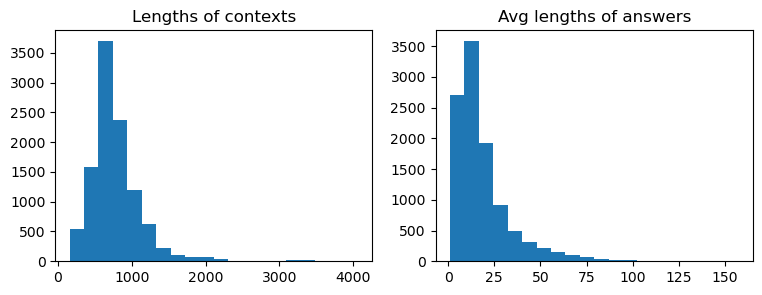

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))

# check context length in the dataset
lengths = []
for cntxt in datasets["validation"]['context']:
    lengths.append(len(cntxt))

plt.subplot(1, 2, 1)
plt.hist(lengths, bins=20)
plt.title(f'Lengths of contexts')

# check answers length in the dataset
m_lengths = []
for answ in datasets["validation"]['answers']:
    m_lengths.append(np.mean([len(a) for a in answ['text']]))
    
plt.subplot(1, 2, 2)
plt.hist(m_lengths, bins=20)
plt.title(f'Avg lengths of answers')
plt.show()


In [80]:
# we will create next datasets:
# len of context < 1000 and len of context >= 1000
# len of answers < 50 and len of answer >= 50

long_contexts_ds = datasets['validation'].filter(lambda example: len(example['context']) >= 1000)
short_contexts_ds = datasets['validation'].filter(lambda example: len(example['context']) < 1000)

def average_answer_length(answers):
    return np.mean([len(a) for a in answers['text']])

long_answers_ds = datasets['validation'].filter(lambda example: average_answer_length(example['answers']) >= 50)
short_answers_ds = datasets['validation'].filter(lambda example: average_answer_length(example['answers']) < 50)

Filter:   0%|          | 0/10570 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10570 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [82]:
print('Evaluation for answers with average length < 50')
predicted_answers, theoretical_answers = collect_answers(short_answers_ds, 200)
print(metric.compute(predictions=predicted_answers, references=theoretical_answers))
print()

print('Evaluation for answers with average length >= 50')
predicted_answers, theoretical_answers = collect_answers(long_answers_ds, 200)
print(metric.compute(predictions=predicted_answers, references=theoretical_answers))
print()

print('Evaluation for context with the length < 1000')
predicted_answers, theoretical_answers = collect_answers(short_contexts_ds, 200)
print(metric.compute(predictions=predicted_answers, references=theoretical_answers))
print()

print('Evaluation for context with the length >= 1000')
predicted_answers, theoretical_answers = collect_answers(long_contexts_ds, 200)
print(metric.compute(predictions=predicted_answers, references=theoretical_answers))

Evaluation for answers with average length < 50
{'exact_match': 84.0, 'f1': 88.78415457091928}

Evaluation for answers with average length >= 50


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'exact_match': 58.0, 'f1': 76.13527818538671}

Evaluation for context with the length < 1000


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'exact_match': 84.0, 'f1': 88.78415457091928}

Evaluation for context with the length >= 1000


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'exact_match': 79.5, 'f1': 84.54080586080586}


The model shows significant deterioration for answers with an average length of > 50 words

BONUS: Can you think of other axes that would be interesting to use to evaluate your model?

- question type: fact-based, opinion-based, wh-questions;
- numeric vs textual answers

### [Advanced] Fine-tune a Model
Here, you will fine-tune a base model to the Squad dataset, and evaluate its performance.

What metric do you find suited? Why?


Train the model to fine-tune on the dataset.

Write below your train and validation loss.

## Recommended Resources
For an open discussion on Question Answering related topics, you are very encouraged to watch this workshop: https://www.youtube.com/watch?v=Ihgk8kGLpIE

This screencast uses T5 on a different Q&A dataset: https://www.youtube.com/watch?v=_l2wJb3QPdk



That's it - good luck!